In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
market=pd.read_excel('Prueba.xlsx', index_col=0)

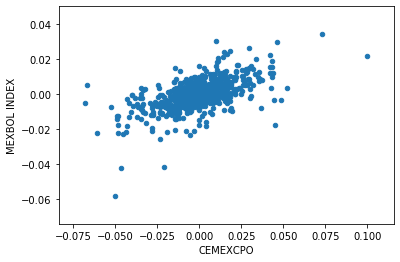

In [3]:
rets=market.pct_change().dropna(axis=0)
rets.columns=[col.replace(" MF Equity","") for col in rets.columns]
rets.plot.scatter(x="CEMEXCPO", y="MEXBOL INDEX")

In [4]:
N=len(rets)
N

672

In [5]:
I=np.concatenate([np.identity(2)]*2,axis=1)
I=np.concatenate([I]*2,axis=0)
I

array([[1., 0., 1., 0.],
       [0., 1., 0., 1.],
       [1., 0., 1., 0.],
       [0., 1., 0., 1.]])

In [6]:
Phi=rets.iloc[:,:-1].values
t=rets.iloc[:,[-1]]
N,M=Phi.shape

I=np.concatenate([np.identity(M)]*2,axis=1)
I=np.concatenate([I]*2,axis=0)

I.shape

(70, 70)

In [7]:
P=np.ones((N,M))
P=np.c_[P,Phi]

In [8]:
W=np.linalg.inv((P.T @ P)* I)@ P.T @ t
W["security"]=np.concatenate([rets.columns[:-1]]*2)
W["param"]=["alpha"]*M+["beta"]*M
B=W.pivot_table(index="security", columns="param", values="MEXBOL INDEX")

In [9]:
from ipywidgets import interact

@interact(security=rets.columns[:-1])
def plot_cmap(security):
    rets.plot.scatter(x=security, y="MEXBOL INDEX")
    sec=rets[security]
    x=np.linspace(sec.min(),sec.max(),100)
    alpha, beta= B.loc[security]
    #plt.title(rf"$\alpha={alpha:o.3f}$ | $\beta={beta:0.3f}$")
    plt.plot(x, alpha +beta*x, c="tab:orange", linewidth=4)

interactive(children=(Dropdown(description='security', options=('KIMBERA', 'GAPB', 'CEMEXCPO', 'ASURB', 'GFNOR…

In [10]:
Datos=pd.read_excel('PreciosPortf.xlsx',index_col=0)

In [11]:
rend=Datos.pct_change().dropna()
rend_ports=rend.mean()*252

In [12]:
rend_ports

ASURB MF Equity       0.123539
GFNORTEO MF Equity    0.078811
PE&OLES* MF Equity    0.111053
WALMEX* MF Equity     0.082426
IENOVA* MF Equity     0.078997
dtype: float64

In [13]:
rend.cov()

,ASURB MF Equity,GFNORTEO MF Equity,PE&OLES* MF Equity,WALMEX* MF Equity,IENOVA* MF Equity
ASURB MF Equity,0.000224,0.000086,0.000061,0.000036,0.000044
GFNORTEO MF Equity,0.000086,0.000341,0.000094,0.000082,0.000082
PE&OLES* MF Equity,0.000061,0.000094,0.000548,0.000041,0.000045
WALMEX* MF Equity,0.000036,0.000082,0.000041,0.000215,0.000043
IENOVA* MF Equity,0.000044,0.000082,0.000045,0.000043,0.000226


In [14]:
random.seed(314)
w = np.random.random(size=5)
w = w / w.sum()

In [15]:
(rend.mean()@w).sum()*252

0.08878116030559108

In [16]:
E_p=(rend.mean()@w)*252
S_p=np.sqrt(w.T@(rend.cov()*252)@w)
V_p=rend.resample('Y').last().pct_change().var(ddof=0)@w

def port_rend(w,r):
    E_p=(r.mean()@w)*252
    return E_p

def port_vol(w,r):
    s_p=np.sqrt(w.T@(rend.cov()*252)@w)
    return s_p

def port_var(w,r):
    v_p=r.resample('Y').last().pct_change().var(ddof=0)@w
    return v_p


In [17]:
weights_sim = np.random.random((5000,5))
weights_sim=weights_sim/weights_sim.sum(axis=1, keepdims=True)

rend_sim= np.apply_along_axis(port_rend, 1, weights_sim, r=rend)
vol_sim= np.apply_along_axis(port_vol, 1, weights_sim, r=rend)

Text(0, 0.5, 'E(r)')

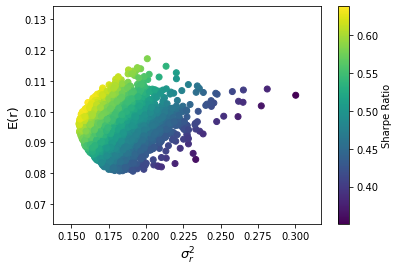

In [18]:
sharpe_ratio = rend_sim / vol_sim
plt.scatter(vol_sim, rend_sim, c=sharpe_ratio)
plt.colorbar(label="Sharpe Ratio")
plt.xlabel(r"$\sigma^2_r$", fontsize=13)
plt.ylabel("E(r)", fontsize=13)

# Frontera eficiente

In [19]:
from scipy.optimize import minimize

In [20]:
N, M  = rend.shape
w0 = np.random.randn(M)

def sum_weights(weights):
    return weights.sum() -1

constraints = [
    {"type":"eq", "fun":sum_weights}
]
port0 = minimize(port_vol, w0, constraints=constraints, args=rend)
port0

     fun: 0.15516188534130798
     jac: array([0.15514752, 0.15516154, 0.15517789, 0.15515104, 0.15518349])
 message: 'Optimization terminated successfully.'
    nfev: 56
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([0.28177485, 0.04418443, 0.08988453, 0.30798267, 0.27617352])

In [21]:
wp0 = port0.x
port_rend(wp0,rend),port_vol(wp0,rend)

(0.09547707549188779, 0.15516188534130798)

# Optimización

In [22]:
N, M  = rend.shape
w0 = np.random.randn(M)

def sum_weights(weights):
    return weights.sum() -1 # == 0

def rend_esperado(w, E):
    return port_rend(w, rend) - E # == 0

e0 = .1
e1 =100
constraints = [
    {"type":"eq", "fun":sum_weights},
    {"type":"eq", "fun":lambda w: rend_esperado(w, e0)},
    #{"type":"ineq", "fun":lambda w: rend_esperado(w, e0)}
    
]
port1 = minimize(port_vol, w0, constraints=constraints, args=rend)
port1

     fun: 0.15715159143104795
     jac: array([0.17786075, 0.13836672, 0.16589243, 0.14204526, 0.13870268])
 message: 'Optimization terminated successfully.'
    nfev: 64
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([0.37290024, 0.00682385, 0.10724716, 0.27895553, 0.23407322])

In [23]:
wp1 = port1.x
port_rend(wp1,rend),port_vol(wp1,rend)

(0.09999999999911587, 0.15715159143104795)

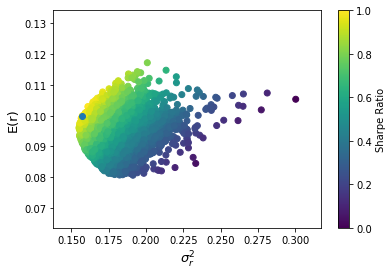

In [24]:
sharpe_ratio = rend_sim / vol_sim
plt.scatter(vol_sim, rend_sim, c = sharpe_ratio)
plt.scatter(port_vol(wp1,rend),port_rend(wp1,rend))
plt.colorbar(label="Sharpe Ratio")
plt.xlabel(r"$\sigma^2_r$", fontsize=13)
plt.ylabel("E(r)",fontsize=13);

In [25]:
rmin = rend_ports.min()
rmax = rend_ports.max()
rend_max = np.linspace(rmin,rmax)

In [26]:
pesos_optimos = []
for e in rend_max:
    constraints = [
        {"type":"eq", "fun":sum_weights},
        {"type":"eq", "fun":lambda w: rend_esperado(w, e)}
    ]
    port1 = minimize(port_vol, w0, constraints=constraints, args=rend)
    w_opt = port1.x
    pesos_optimos.append(w_opt)

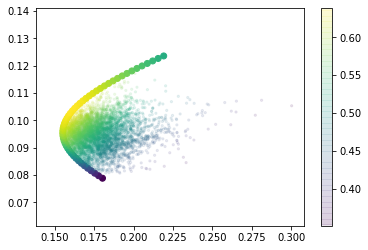

In [27]:
r_opt = []
v_opt = []
for w in pesos_optimos:
    r_opt.append(port_rend(w,rend))
    v_opt.append(port_vol(w,rend))
r_opt = np.array(r_opt)
v_opt = np.array(v_opt)

plt.scatter(v_opt,r_opt, c=r_opt/v_opt)
plt.scatter(vol_sim,rend_sim, c=sharpe_ratio, alpha = 0.1, s=5)
plt.colorbar()

# Portafolio Tangencial

In [28]:
rf = 0.06
def min_func_sharpe(weights):
        return - (port_rend(weights, rend) - rf)/ port_vol(weights,rend)

constraints = [
    {"type":"eq", "fun":sum_weights}
]
f_sharpe = minimize(min_func_sharpe,w0, constraints=constraints)

In [29]:
w_sharpe = f_sharpe.x

In [30]:
w_sharpe

array([ 0.73082677, -0.14047753,  0.17616637,  0.16460521,  0.06887919])

In [31]:
e_sharpe = port_rend(w_sharpe, rend)
vol_sharpe = port_vol(w_sharpe, rend)

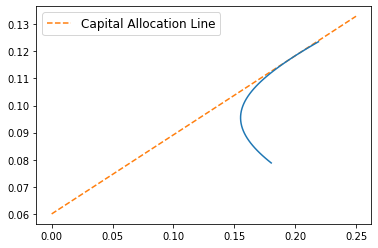

In [32]:
sigma_c = np.linspace(0,0.25)
sharpe = rf + sigma_c*(e_sharpe - rf)/vol_sharpe
plt.plot(sigma_c, sharpe, linestyle="--",c="tab:orange", label="Capital Allocation Line")
plt.plot(v_opt, r_opt)
plt.plot()
plt.legend(fontsize=12)

# VaR

Se ocupa los pesos del portafolio optimo dado por el coeficiente de Sharpe, que fue calculado en la clase anterior.

In [33]:
from scipy.stats import norm

In [61]:
# VaR diaria, ya que la volatilidad en la formula está anualizada

S=10_000_000
conf=float(input("confianza para el cálculo: "))
F=norm.ppf(conf)

VaR=S*F*port_vol(w_sharpe,rend)*1/np.sqrt(252)

print(f"VaR diaria = {VaR:,.2f}")
print(f"VaR anual = {VaR*np.sqrt(252):,.2f}")
port_vol(w_sharpe,rend)

confianza para el cálculo: .95
VaR diaria = 205,162.17
VaR anual = 3,256,848.47


0.1980023277560398

In [62]:
w=np.array([.2455,.0523,.1218,.3026,.2778])

VaR=S*F*port_vol(w,rend)*1/np.sqrt(252)

print(f"VaR diaria = {VaR:,.2f}")
print(f"VaR anual = {VaR*np.sqrt(252):,.2f}")
print(port_vol(w,rend))

VaR diaria = 161,389.50
VaR anual = 2,561,978.94
0.15575725978832383


# VaR individual por accion

In [72]:
vol_ind=(rend.cov()*np.identity(5)).sum()**.5
vol_ind

ASURB MF Equity       0.014960
GFNORTEO MF Equity    0.018476
PE&OLES* MF Equity    0.023406
WALMEX* MF Equity     0.014669
IENOVA* MF Equity     0.015019
dtype: float64

In [73]:
# Diario
VaR=w_sharpe*S*F*vol_ind
VaR.sum()

261692.3570425886

In [74]:
# Anual
(VaR*np.sqrt(252))

ASURB MF Equity       2.854716e+06
GFNORTEO MF Equity   -6.777064e+05
PE&OLES* MF Equity    1.076639e+06
WALMEX* MF Equity     6.304625e+05
IENOVA* MF Equity     2.701258e+05
dtype: float64

In [75]:
(VaR*np.sqrt(252)).sum()

4154237.380446071

El VaR por accion individual es mayor que el VaR del portafolio, por lo que el valor en riesgo es mayor invertir individualmente.